In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import random_split, Dataset, DataLoader

from transformers import BertTokenizer, BertModel
from torchinfo import summary
from tqdm.auto import tqdm
from typing import Tuple, Dict, List

plt.rcParams["font.family"] = "monospace"
plt.rcParams["xtick.labelsize"] = 9
plt.rcParams["ytick.labelsize"] = 9

torch.manual_seed(12)

DATA_DIR = "/kaggle/input/map-charting-student-math-misunderstandings"
TRAIN_DATA = f"{DATA_DIR}/train.csv"
TEST_DATA = f"{DATA_DIR}/test.csv"

2025-09-09 07:56:50.152336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757404610.343289      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757404610.400512      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Exploratory Data Analysis

The first step in solving this challenge is to understand the data and what are the expectations for the final submission. Furthermore, this step will do the necessary data pre-processing to create a PyTorch dataset.

In [2]:
def print_qa(row: pd.DataFrame) -> None:
    print(f"Q: {row['QuestionText']}")
    print(f"A: {row['MC_Answer']}")
    print(f"E: {row['StudentExplanation']}")

In [3]:
df_train = pd.read_csv(TRAIN_DATA)
print_qa(df_train.iloc[0])

Q: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]
A: \( \frac{1}{3} \)
E: 0ne third is equal to tree nineth


In [4]:
df_train["Misconception"] = df_train["Misconception"].fillna("NA")
df_train["Category"], category_labels = pd.factorize(df_train["Category"])
df_train["Misconception"], misconception_labels = pd.factorize(df_train["Misconception"])

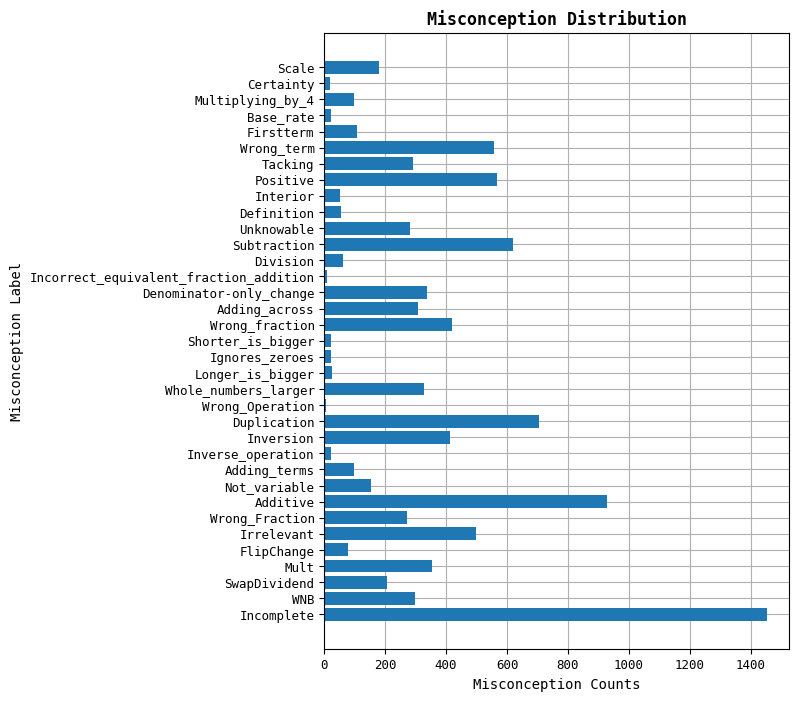

In [5]:
misconception_counts = df_train.groupby("Misconception")["Misconception"].count()

plt.figure(figsize=(6, 8))
plt.barh(
    misconception_labels[1:],
    misconception_counts[1:],
    zorder=2,
)

plt.xlabel("Misconception Counts")
plt.ylabel("Misconception Label")
plt.title("Misconception Distribution", fontweight="bold")
plt.grid(zorder=0)
plt.show()

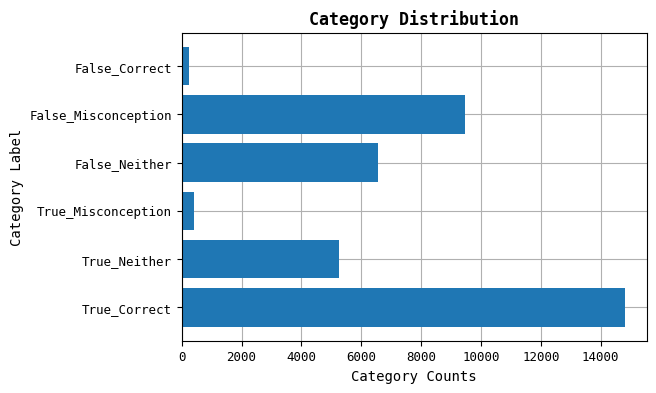

In [6]:
category_counts = df_train.groupby("Category")["Category"].count()

plt.figure(figsize=(6, 4))
plt.barh(
    category_labels,
    category_counts,
    zorder=2
)

plt.xlabel("Category Counts")
plt.ylabel("Category Label")
plt.title("Category Distribution", fontweight="bold")
plt.grid(zorder=0)
plt.show()

## PyTorch Dataset

In [7]:
_Input = Dict[str, str]

NUM_CAT = len(category_labels)
NUM_MIS = len(misconception_labels)

class MisconceptionDataset(Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> Tuple[_Input, torch.Tensor]:
        row = self.df.loc[idx]
        # input
        question = row["QuestionText"]
        answer = row["MC_Answer"]
        explanation = row["StudentExplanation"]

        # output
        category = row["Category"]
        misconception = row["Misconception"]

        i = {
            "question": question,
            "answer": answer,
            "explanation": explanation
        }
        o = torch.tensor(category*NUM_MIS + misconception, dtype=torch.long)

        return i, o

In [8]:
dataset = MisconceptionDataset(df_train)
print(f"Dataset Size: {len(dataset):,}")

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(f"Train Dataset Size: {len(train_dataset):,}")
print(f"Validation Dataset Size: {len(val_dataset):,}")

Dataset Size: 36,696
Train Dataset Size: 33,026
Validation Dataset Size: 3,670


In [9]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train Batches: {len(train_loader):,}")
print(f"Validation Batches: {len(val_loader):,}")

Train Batches: 2,065
Validation Batches: 230


## Model and Training

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class MathBertModel(nn.Module):
    def __init__(self) -> None:
        super(MathBertModel, self).__init__()

        self.bert_tokenizer = BertTokenizer.from_pretrained("/kaggle/input/mathbert/other/model/1")
        self.bert_model = BertModel.from_pretrained("/kaggle/input/mathbert/other/model/1")
        bert_dim = 768
        hidden_dim = 128

        self.flatten = nn.Flatten()
        self.embd_head = nn.Linear(3*bert_dim, hidden_dim)
        self.pred_head = nn.Linear(hidden_dim, NUM_CAT*NUM_MIS)

    def forward(self, input: List[_Input]) -> torch.Tensor:
        input_tokens = []
        for _, text in input.items():
            tokens = self.bert_tokenizer(text, return_tensors="pt", padding=True)
            for key, val in tokens.items():
                if val is not None:
                    tokens[key] = val.to(device)
            input_tokens.append(tokens)

        output_embds = [
            self.bert_model(**tokens).pooler_output.unsqueeze(1)
            for tokens in input_tokens
        ]
        output_embds = torch.concat(output_embds, dim=1)
        output_embds = self.flatten(output_embds)
        
        embd = self.embd_head(output_embds)
        output = self.pred_head(embd)

        return output

In [11]:
model = MathBertModel().to(device)
summary(model)

Layer (type:depth-idx)                                       Param #
MathBertModel                                                --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   23,440,896
│    │    └─Embedding: 3-2                                   393,216
│    │    └─Embedding: 3-3                                   1,536
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  85,054,464
│    └─BertPooler: 2-3                                       --
│    │    └─Linear: 3-7                                      590,592
│    │    └─Tanh: 3-8                                        --
├─Flatten: 1-2                                               --
├─L

In [12]:
def val_epoch(
    model: nn.Module,
    val_loader: DataLoader,
    loss_fn: nn.Module
) -> float:
    model.eval()
    
    num_batches, val_loss = len(val_loader), 0.0
    for X, y in val_loader:
        with torch.no_grad():
            val_loss += loss_fn(model(X), y.to(device)).item()

    return val_loss/num_batches

In [13]:
def train_epoch(
    model: nn.Module,
    train_loader: DataLoader,
    loss_fn: nn.Module,
    optim: torch.optim.Optimizer,
    desc: str
) -> float:
    model.train()

    num_batches, train_loss = len(train_loader), 0.0
    pbar = tqdm(train_loader, desc=desc, leave=False)

    for batch, (X, y) in enumerate(pbar, start=1):
        pred = model(X)
        loss = loss_fn(pred, y.to(device))

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_loss += loss.item()
        pbar.set_postfix({
            "Batch Loss": f"{loss.item():.4f}",
            "Train Loss": f"{train_loss/batch:.4f}"
        })

    pbar.close()
    return train_loss/num_batches

In [14]:
epochs = 20
optim = torch.optim.Adam([
    {"params": model.bert_model.encoder.parameters(), "lr": 1e-6},
    {"params": model.embd_head.parameters(), "lr": 1e-3},
    {"params": model.pred_head.parameters(), "lr": 1e-3}
])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=epochs)

loss_fn = nn.CrossEntropyLoss()

In [15]:
train_losses, val_losses = [], []

for epoch in range(1, epochs+1):
    desc = f"Epoch [{epoch:02d}/{epochs}]"
    train_loss = train_epoch(model, train_loader, loss_fn, optim, desc)
    val_loss = val_epoch(model, val_loader, loss_fn)

    scheduler.step()
    lrs = np.array([g['lr'] for g in optim.param_groups])
    lrs = np.array2string(lrs, formatter={"float_kind": lambda x: f"{x:.2e}"})
    print(f"{desc}:\tTrain Loss: {train_loss:.4f}\tVal Loss: {val_loss:.4f}\tLRs: {lrs}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

Epoch [01/20]:   0%|          | 0/2065 [00:00<?, ?it/s]

Epoch [01/20]:	Train Loss: 0.8270	Val Loss: 0.6081	LRs: [9.94e-07 9.94e-04 9.94e-04]


Epoch [02/20]:   0%|          | 0/2065 [00:00<?, ?it/s]

Epoch [02/20]:	Train Loss: 0.5773	Val Loss: 0.5899	LRs: [9.76e-07 9.76e-04 9.76e-04]


Epoch [03/20]:   0%|          | 0/2065 [00:00<?, ?it/s]

Epoch [03/20]:	Train Loss: 0.5314	Val Loss: 0.5600	LRs: [9.46e-07 9.46e-04 9.46e-04]


Epoch [04/20]:   0%|          | 0/2065 [00:00<?, ?it/s]

Epoch [04/20]:	Train Loss: 0.4896	Val Loss: 0.5147	LRs: [9.05e-07 9.05e-04 9.05e-04]


Epoch [05/20]:   0%|          | 0/2065 [00:00<?, ?it/s]

Epoch [05/20]:	Train Loss: 0.4510	Val Loss: 0.4898	LRs: [8.54e-07 8.54e-04 8.54e-04]


Epoch [06/20]:   0%|          | 0/2065 [00:00<?, ?it/s]

Epoch [06/20]:	Train Loss: 0.4206	Val Loss: 0.4942	LRs: [7.94e-07 7.94e-04 7.94e-04]


Epoch [07/20]:   0%|          | 0/2065 [00:00<?, ?it/s]

Epoch [07/20]:	Train Loss: 0.3927	Val Loss: 0.5004	LRs: [7.27e-07 7.27e-04 7.27e-04]


Epoch [08/20]:   0%|          | 0/2065 [00:00<?, ?it/s]

Epoch [08/20]:	Train Loss: 0.3686	Val Loss: 0.4729	LRs: [6.55e-07 6.55e-04 6.55e-04]


Epoch [09/20]:   0%|          | 0/2065 [00:00<?, ?it/s]

Epoch [09/20]:	Train Loss: 0.3434	Val Loss: 0.4374	LRs: [5.78e-07 5.78e-04 5.78e-04]


Epoch [10/20]:   0%|          | 0/2065 [00:00<?, ?it/s]

Epoch [10/20]:	Train Loss: 0.3283	Val Loss: 0.4279	LRs: [5.00e-07 5.00e-04 5.00e-04]


Epoch [11/20]:   0%|          | 0/2065 [00:00<?, ?it/s]

Epoch [11/20]:	Train Loss: 0.3021	Val Loss: 0.4206	LRs: [4.22e-07 4.22e-04 4.22e-04]


Epoch [12/20]:   0%|          | 0/2065 [00:00<?, ?it/s]

Epoch [12/20]:	Train Loss: 0.2862	Val Loss: 0.4487	LRs: [3.45e-07 3.45e-04 3.45e-04]


Epoch [13/20]:   0%|          | 0/2065 [00:00<?, ?it/s]

Epoch [13/20]:	Train Loss: 0.2690	Val Loss: 0.4494	LRs: [2.73e-07 2.73e-04 2.73e-04]


Epoch [14/20]:   0%|          | 0/2065 [00:00<?, ?it/s]

Epoch [14/20]:	Train Loss: 0.2583	Val Loss: 0.4415	LRs: [2.06e-07 2.06e-04 2.06e-04]


Epoch [15/20]:   0%|          | 0/2065 [00:00<?, ?it/s]

Epoch [15/20]:	Train Loss: 0.2425	Val Loss: 0.4294	LRs: [1.46e-07 1.46e-04 1.46e-04]


Epoch [16/20]:   0%|          | 0/2065 [00:00<?, ?it/s]

Epoch [16/20]:	Train Loss: 0.2346	Val Loss: 0.4305	LRs: [9.55e-08 9.55e-05 9.55e-05]


Epoch [17/20]:   0%|          | 0/2065 [00:00<?, ?it/s]

Epoch [17/20]:	Train Loss: 0.2252	Val Loss: 0.4321	LRs: [5.45e-08 5.45e-05 5.45e-05]


Epoch [18/20]:   0%|          | 0/2065 [00:00<?, ?it/s]

Epoch [18/20]:	Train Loss: 0.2203	Val Loss: 0.4330	LRs: [2.45e-08 2.45e-05 2.45e-05]


Epoch [19/20]:   0%|          | 0/2065 [00:00<?, ?it/s]

Epoch [19/20]:	Train Loss: 0.2167	Val Loss: 0.4342	LRs: [6.16e-09 6.16e-06 6.16e-06]


Epoch [20/20]:   0%|          | 0/2065 [00:00<?, ?it/s]

Epoch [20/20]:	Train Loss: 0.2169	Val Loss: 0.4309	LRs: [0.00e+00 0.00e+00 0.00e+00]


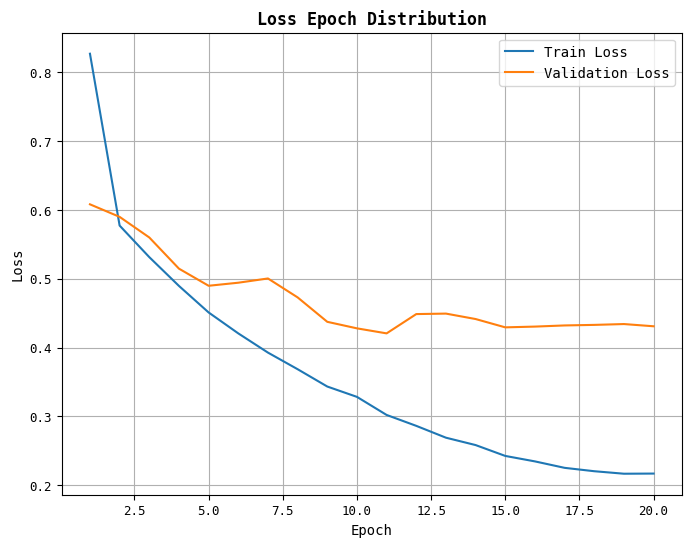

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Epoch Distribution", fontweight="bold")
plt.legend()
plt.grid()

plt.show()

## Evaluating on Validation Data

In [17]:
def evaluate(test_loader: DataLoader, k: int = 3) -> float:
    model.eval()
    
    num_samples, score = 0, 0.0
    for X, y in tqdm(test_loader, desc="Evaluating Model", leave=False):
        with torch.no_grad():
            pred = model(X)
            _, top_indices = torch.topk(pred, k=k)

        for true_label, preds in zip(y, top_indices):
            preds = preds.cpu().numpy().tolist()
            true_label = true_label.item()

            ap = 0.0
            if true_label in preds:
                rank = preds.index(true_label) + 1
                ap = 1.0/rank

            score += ap
            num_samples += 1

    score /= num_samples
    return score

In [18]:
map_3 = evaluate(val_loader, k=3)
print(f"Validation Set MAP@3 = {map_3:.4f}")

Evaluating Model:   0%|          | 0/230 [00:00<?, ?it/s]

Validation Set MAP@3 = 0.9270


## Generate Final Submission

In [19]:
model.eval()

def generate_submission(path: str) -> pd.DataFrame:
    submission_dict = {
        "row_id": [],
        "Category:Misconception": []
    }
    
    df_test = pd.read_csv(TEST_DATA)
    for i in tqdm(range(len(df_test)), "Generating Submission", leave=False):
        row = df_test.loc[i]
        X = {
            "question": row["QuestionText"],
            "answer": row["MC_Answer"],
            "explanation": row["StudentExplanation"],
        }
        with torch.no_grad():
            logits = model(X)[0]
            _, top_indices = torch.topk(logits, k=3)
            idx_1 = (top_indices // NUM_MIS).cpu().numpy()
            idx_2 = (top_indices % NUM_MIS).cpu().numpy()

        submission_dict["row_id"].append(row["row_id"])
        cat_mis = ""
        for i, (i1, i2) in enumerate(zip(idx_1, idx_2)):
            cat = category_labels[i1]
            mis = misconception_labels[i2]
                
            cat_mis += f"{cat}:{mis}"
            if i < 3:
                cat_mis += " "

        submission_dict["Category:Misconception"].append(cat_mis)
    
    sub_df = pd.DataFrame(submission_dict)
    sub_df.to_csv(path, index=False)

    return sub_df    

In [20]:
sub_df = generate_submission("/kaggle/working/submission.csv")
sub_df.head()

Generating Submission:   0%|          | 0/3 [00:00<?, ?it/s]

,row_id,Category:Misconception
0,36696,True_Correct:NA True_Neither:NA True_Misconcep...
1,36697,False_Misconception:WNB False_Neither:NA False...
2,36698,True_Neither:NA True_Correct:NA True_Misconcep...
